# 3.3.1 Детекция (выделение) объектов на изображениях (Object Detection)


Задача **детекции объектов** - это поиск объекта на изображении и выделение его рамкой.

В этой области есть различные варианты моделей и подходы, но далеко не все они обладают достаточным быстродействием и оптимизированы по производительности. Поэтому, большее внимание уделим использованию архитектуры YOLO или комплексной модели, в которой есть также сегментация, о чём поговорим ниже.

Архитектура
YOLOv5 относится к архитектуре One-Stage detector - подход, который предсказывает координаты определённого количества bounding box'ов с результатами классификации и вероятности нахождения объекта, и в дальнейшем корректируя их местоположение. В целом такую архитектуру можно представить в следующем виде:




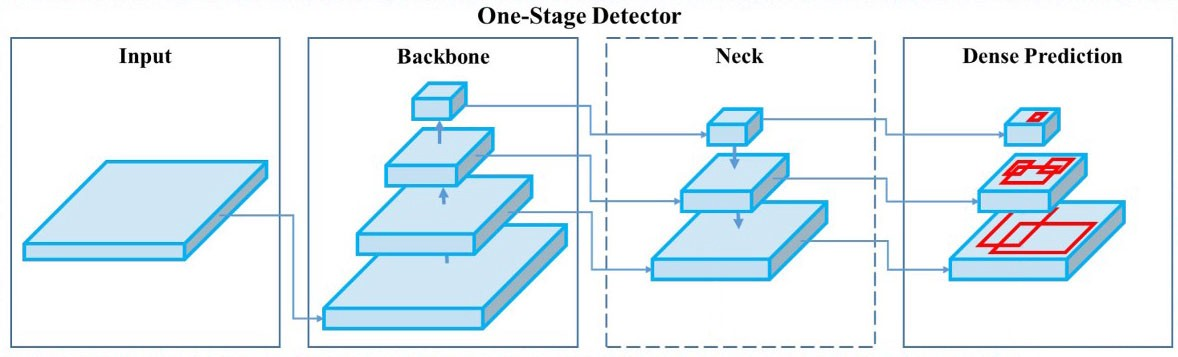

Сеть масштабирует исходное изображение в несколько feature map'ов с использованием skip-connection и прочих архитектурных решений. Суть масштабирования в том, что сеть может "не узнать" объекты разных масштабов, если масштабы, а значит, и отдельные их детали, выделяемые свёрточной сетью, будут отличаться в несколько раз от тех, на которых сеть обучена. Поэтому, сеть делает массивы картинок разных масштабов и каждый масштаб анализирует. Полученные карты признаков приводятся в одно разрешение с помощью апсемплинга и конкатенируются. Затем предсказываются классы и bounding box'ы (баундин боксы, т.е. прямоугольники, выделяющие нужные объекты на изображении) для объектов, далее для каждого объекта выбирается самый вероятный bounding box с помощью Non-Maximum Suppression. Подробнее можно почитать на Medium, ссылка есть в конце ноутбука. Да, статья на Medium про YOLOv4, но отличие v5 только в том, что v5 реализована на pytorch. Пусть вас не смущает, что она на английском, онлайн переводчик всегда может решить эту проблему.

## Устанавливаем библиотеку с моделью детекции объектов

In [ ]:
!pip install ultralytics

## Загружаем модули

In [ ]:
from IPython.display import Javascript
from IPython.display import Image as Image2
from IPython import display
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import torch
from PIL import Image as Image1
import gc

## Загружаем и настраиваем детекцию

In [ ]:
#Устанавливаем Yolo V5 (large) для распознавания

detector = torch.hub.load('ultralytics/yolov5', 'custom',
                              path = 'yolov5m.pt') #'yolov5s.pt'
print('#'*60)
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'}), OpenCV: {cv2.__version__}")

In [ ]:
# Список детектируемых классов
coco_labels = '''person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
street sign
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
hat
backpack
umbrella
shoe
eye glasses
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
plate
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
mirror
dining table
window
desk
toilet
door
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
blender
book
clock
vase
scissors
teddy bear
hair drier
toothbrush
hair brush'''.split()

### Делаем детекцию объектов на изображении

In [ ]:
#!wget https://minlife.ru/wp-content/uploads/2019/02/%D0%AF-%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE-%D0%BF%D1%8B%D1%82%D0%B0%D1%8E%D1%81%D1%8C-%D0%B1%D1%8B%D1%82%D1%8C-%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D0%BA%D0%BE%D0%BC.jpg -O detect.jpg
!wget https://www.oum.ru/upload/resize_cache/iblock/b8e/706_294_1/b8ecdbc3ea34af5f7875adabe398488d.jpg -O detect.jpg
image_path = 'detect.jpg'
img = Image1.open(image_path)
img = np.array(img)
img = cv2.resize(img, (1040,480))

display.display(display.Image(image_path, width=1024))

In [ ]:
# детекция
cur = detector(img)
yolo_preds = cur.xyxy[0].cpu().numpy()

# получение коодинат прямоугольников
boxes = yolo_preds[:, :4]  # xmin, ymin, xmax, ymax
confs = yolo_preds[:, 4]
labels = yolo_preds[:, 5]

fst_box_flag = 1

# получаем конкретные прямоугольники
for box, conf, label in zip(boxes, confs, labels):
    if coco_labels[int(label)] == 'person': #and fst_box_flag == 1: #
        #x1, x2, y1, y2 = int(box[1]), int(box[3]), int(box[0]), int(box[2])
        y1, y2, x1, x2 = int(box[1]), int(box[3]), int(box[0]), int(box[2])

        img = cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2) # рисуем прямоугольник
        fst_box_flag = 0

output_image_path = 'detection_results.jpg'
Image1.fromarray(img.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

# 3.3.2 Использование компьютерного зрения (CV) в видео

### Видеозахват на своём компьютере


In [ ]:
# Как это производится на локальном компьютере. В Колабе работать не будет.

cap = cv2.VideoCapture(0) # or cap = cv2.VideoCapture("<video-path>")

def run_inference(detector, cap):
    while cap.isOpened():
        ret, img = cap.read()

        # детекция
        cur = detector(img) #img
        yolo_preds = cur.xyxy[0].cpu().numpy()

        # получение коодинат прямоугольников
        boxes = yolo_preds[:, :4]  # xmin, ymin, xmax, ymax
        confs = yolo_preds[:, 4]
        labels = yolo_preds[:, 5]

        fst_box_flag = 1

        # получаем конкретные прямоугольники
        for box, conf, label in zip(boxes, confs, labels):
            if coco_labels[int(label)] == 'person' and fst_box_flag == 1: #
                y1, y2, x1, x2 = int(box[1]), int(box[3]), int(box[0]), int(box[2])

                img = cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2) # рисуем прямоугольник
                fst_box_flag = 0

        cv2_imshow(cv2.resize(img, (800, 600)))

        if cv2.waitKey(25) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

run_inference(detector, cap)

### Видеозахват в Колабе

In [ ]:
# функция преобразования объекта JavaScript в изображение OpenCV image - надо запускать также для следующего раздела
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # декодируем изображение из формата base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # конвертируем байты в numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # декодируем numpy array в изображение OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# функция для преобразования изображения с прямоугольником OpenCV Rectangle bounding box image в байтовую строку base64 чтобы вывести в видеопоток
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # конвертируем массив в изображение PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # преобразуем bbox в формат png для возврата из функции с помощью return
  bbox_PIL.save(iobuf, format='png')
  # форматируем возвращаемую с помощью return строку
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# Используем код на JavaScript для захвата потока с нашей вебкамеры и передачи данных на облачный компьютер - надо запускать также для следующего раздела
def video_stream_js():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Чтобы завершить, щёлкните мышкой на данном видео</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display.display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# получаем прямоугольники(баундбоксы) - в кадре должен быть человек
# очищаем память
gc.collect()

# начинаем захват видео с камеры
video_stream_js()

# Создаём надпись
label_html = 'Захват изображения...'

# инициализируем пустые прямоугольники выделения
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # конвертируем поток, передаваемый через JS, в изображение OpenCV Image
    img = js_to_image(js_reply["img"])

    # создаём пустой массив, в котором будет отображаться детекция объектов
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # переводим изображение в серое для детекции
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # детектирование
    cur = detector(img) #img
    yolo_preds = cur.xyxy[0].cpu().numpy()

    # получение коодинат прямоугольников
    boxes = yolo_preds[:, :4]  # xmin, ymin, xmax, ymax
    confs = yolo_preds[:, 4]
    labels = yolo_preds[:, 5]

    fst_box_flag = 1

    # получаем конкретные прямоугольники
    for box, conf, label in zip(boxes, confs, labels):
        if coco_labels[int(label)] == 'person' and fst_box_flag == 1: #
             y1, y2, x1, x2 = int(box[1]), int(box[3]), int(box[0]), int(box[2])
             bbox_array = cv2.rectangle(bbox_array,(x1,y1),(x2,y2),(0,255,0),2)
             fst_box_flag = 0

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    bbox_bytes = bbox_to_bytes(bbox_array) #bbox_array
    # записываем в конкретные массивы изображения с прямоугольниками
    bbox = bbox_bytes

# 3.3.3 Классификация точек объектов (сегментация) изображений

##Что такое сегментация?

В широком смысле «сегментация», как следует из Оксфордского словаря, — это разделение чего-либо на несколько частей, либо одна из таких частей. В нашем случае сегментация — это задача в компьютерном зрении, которая позволяет разделить цифровое изображение на разные части (сегменты) в соответствии с тем, какому объекту какие пиксели принадлежат. Таким образом мы получаем попиксельную маску объекта.

##Виды сегментации:

Семантическая сегментация (Semantic segmentation) — определяет принадлежность наборов пикселей на изображении к определенным классам объектов (например, кошки, собаки, люди, цветы, автомобили и т.д.).
Инстанс-сегментация (Instance segmentation) — в отличие от семантической сегментации, в этой задаче каждый объект внутри одного класса выделяется отдельными сегментами. Например, если на изображении пять кошек, две собаки и десять растений, семантическая сегментация просто выделит все области, на которых есть кошки, собаки или растения, не разделяя отдельные объекты внутри каждого класса (определит, что на изображении есть кошки, собаки и растения), в то время как инстанс-сегментация выделит каждую кошку, собаку и растение как отдельный объект.
Паноптическая сегментация (Panoptic segmentation) — объединяет задачи семантической и инстанс-сегментации. Также в задаче паноптической сегментации каждому пикселю изображения должна быть присвоена ровно одна метка.

###Зачем она нужна?

Применений сегментации изображений масса. Семантическая и инстанс-сегментация могут использоваться в беспилотных автомобилях и роботах. Камеры служат для получения точной визуальной информации об окружающей среде (наряду с остальной информацией от датчиков и сенсоров), но критически важное условие правильной работы — насколько хорошо алгоритм понимает, что сейчас окружает робота.

Другая область применения — медицина, где с помощью семантической или инстанс-сегментации можно проанализировать рентгенографические и электронно-микроскопические снимки — например, в стоматологии, пульмонологии, онкологии, генетике и т.д. С помощью сегментации анализируют спутниковые изображения и карты, скопления людей и объекты глубокого космоса.

##Интерактивная сегментация изображений

Ручная разметка позволила собрать датасеты (например, ImageNet и Microsoft COCO), лежащие в основе всех современных достижений компьютерного зрения. Один из самых ценных и трудоёмких видов разметки — сегментация изображений. Отличие интерактивной сегментации в том, что она требует участия пользователя на протяжении всего процесса. В частности, пользователь может выделять нужные объекты и исправлять ошибки алгоритма с помощью кликов. Интерактивная сегментация может использоваться в различных приложениях и для редактирования изображений. Например, в Paint 3D на Windows 10 есть функция выделения областей изображения кликом.

## ShapeMask Instance Segmentation
Этот пример Colab демонстрирует, как использовать модель ShapeMask, обученную на Cloud TPU, для выполнения сегментации экземпляра (инстанс сегментации) на образце входного изображения. Результирующие прогнозы накладываются на образец изображения в виде полей, масок экземпляров и меток. Вы также можете поэкспериментировать со своими собственными изображениями, отредактировав URL входного изображения.

### About ShapeMask
Сегментация экземпляров может идентифицировать и выделять несколько экземпляров различных объектов на изображении. Например, на семейной фотографии с несколькими людьми модель этого типа автоматически выделяла каждого человека своим цветом. Примеры таких моделей сегментации экземпляров включают Mask R-CNN и ShapeMask.

Как правило, модель сегментации экземпляра создает поля обнаружения для различных объектов на первом этапе и использует эти поля для определения точных границ объекта и выделения этих объектов на втором этапе. ShapeMask использует уникальную технику на втором этапе — она не зависит критически от начальных полей обнаружения для определения точных границ объекта. Вместо этого алгоритм изучает формы различных объектов, просматривая сходство между соседними пикселями. Этот метод помогает ShapeMask в конце давать более точные результаты даже для некоторых категорий объектов, которые не были замечены во время обучения.  

### Инструкции применения модели детекции объектов + сегментации
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;В исходном применениии используется бесплатный ресурс Cloud TPU</h3>

**Внимание!** В данном применении ничего не нужно переключать. Но если захотите использовать TPU для ускорения:

    1. В главном меню щелкните Среда выполнения и выберите **Изменить тип среды выполнения**. Установите «TPU» в качестве аппаратного ускорителя.
    2. Еще раз щелкните Runtime и выберите **Runtime > Run All**. Вы также можете запускать ячейки вручную с помощью Shift-ENTER.

### Клонируем исходный код модели ShapeMask из репозитория

In [ ]:
!git clone -b shapemask https://github.com/tensorflow/tpu/

In [ ]:
# смещаем указатель в удобную папку
%cd '/content/tpu/models/official/detection/utils/object_detection'

In [ ]:
# смотрим, что в ней
!ls

In [ ]:
# переделываем часть строк в файлах Python чтобы не получать ошибку из-за дублирования названия функции из ultralytics
with open ('/content/tpu/models/official/detection/utils/object_detection/visualization_utils.py', 'r') as f:
  old_data = f.read()

new_data = old_data.replace('from utils.object_detection import shape_utils', 'import shape_utils')

with open ('/content/tpu/models/official/detection/utils/object_detection/visualization_utils.py', 'w') as f:
  f.write(new_data)


with open ('/content/tpu/models/official/detection/evaluation/coco_utils.py', 'r') as f:
  old_data = f.read()

new_data = old_data.replace('from utils import box_utils', 'from detection.utils1 import box_utils')

with open ('/content/tpu/models/official/detection/evaluation/coco_utils.py', 'w') as f:
  f.write(new_data)

In [ ]:
# переносим папку с функциями чтобы они не пересекались по названию с ultralytics
!mv '/content/tpu/models/official/detection/utils/' '/content/tpu/models/official/detection/utils1/'

### Импортируем недостающие библиотеки

In [ ]:
import tensorflow.compat.v1 as tf
from PIL import Image as Image1
import sys

# добавляем системные пути чтобы найти модули
sys.path.insert(0, '/content/tpu/models/official')
sys.path.insert(0, '/content/tpu/models/official/detection')
sys.path.insert(0, '/content/tpu/models/official/detection/utils')
sys.path.insert(0, '/content/tpu/models/official/detection/utils/object_detection')
sys.path.insert(0, '/content/tpu/models/official/detection/utils1')
sys.path.insert(0, '/content/tpu/models/official/detection/utils1/object_detection')

# теперь импортируем перемещённые модули
from utils1.object_detection import visualization_utils
from evaluation import coco_utils


# часть библиотек импортированы в предыдущем разделе

#import numpy as np
#from google.colab.output import eval_js
#from google.colab.patches import cv2_imshow
#from base64 import b64decode, b64encode
#import cv2
#import PIL
#import io
#import html
#import time
#import torch

#from IPython.display import Javascript
#from IPython import display
#from IPython.display import Image as Image2

### Загрузим сопоставление индекса набора данных COCO
В этом ноутбуке используется предварительно обученная контрольная точка модели ShapeMask, которая обучается с использованием набора данных COCO. Ниже видим сопоставление между индексами, которые предсказывает модель, и категориями в тексте.

In [ ]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

### Загрузим изображение
Теперь вы можете загрузить изображение. Используйте приведенный здесь пример изображения или обновите поле изображением по вашему выбору.

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Kitano_Street_Kobe01s5s4110.jpg/2560px-Kitano_Street_Kobe01s5s4110.jpg -O test.jpg
image_path = 'test.jpg'

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])

image = Image1.open(image_path)
width, height = image.size
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

In [ ]:
Image1.fromarray(np_image).save(f"/content/1.jpg")

In [ ]:
with open(f"/content/1.jpg", 'rb') as f:
  np_image_string_idx = np.array([f.read()])
np_image_string_idx.shape

### Создаём сессию Tensorflow
Создайте сеанс Tensorflow, чтобы запустить вывод (inference). Вы можете подключиться либо к TPU, либо к обычному центральному процессору.

In [ ]:
#use_tpu = True #@param {type:"boolean"}
use_tpu = False # мы делаем на GPU, поэтому отключаем поддержку TPU
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

### Загрузим предварительно обученную модель
Загрузка предварительно обученной сохраненной модели COCO из общедоступной корзины GCS.

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/shapemask/1571767330' #@param {type:"string"}
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

### Выполним сегментацию экземпляра и получите прогнозы
Теперь давайте запустим вывод и обработаем прогнозы модели.


In [ ]:
np_image_string.shape

In [ ]:
np_image_string

In [ ]:
# производим детектирование прямоугольников и сегментацию
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]

# Используем внешние прямоугольники (баундбоксы) и сегментируем
ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

### Визуализируем результаты обнаружения
Время проверить результат!

In [ ]:
max_boxes_to_draw = 25   #@param {type:"integer"}
min_score_thresh = 0.20    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image * 1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations, # инстанс сегментация
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh
    )

output_image_path = 'test_results.png'
Image1.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=2048)) #1024

## Запуск модели на видео

In [ ]:
# здесь нужны функции захвата из предыдущего раздела

# показываем только один прямоугольник
max_boxes_to_draw = 1

# получаем прямоугольники(баундбоксы) и сегментацию - в кадре должен быть человек
# очищаем память
gc.collect()

# начинаем захват видео с камеры
video_stream_js()

# Создаём надпись
label_html = 'Захват видео...'

# инициализируем пустые прямоугольники выделения
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # конвертируем поток, передаваемый через JS, в изображение OpenCV Image
    img = js_to_image(js_reply["img"])

    # создаём пустой массив, в котором будет отображаться детекция объектов
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # переводим изображение в серое для детекции
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # детектирование
    height, width, _ = img.shape
    Image1.fromarray(img).save(f"/content/1.jpg")

    with open(f"/content/1.jpg", 'rb') as f:
        np_image_string_idx = np.array([f.read()])

    num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
        ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0',
         'DetectionMasks:0', 'DetectionOuterBoxes:0', 'ImageInfo:0'],
        feed_dict={'Placeholder:0': np_image_string_idx})

    num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
    detection_boxes = np.squeeze(detection_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
    detection_outer_boxes = np.squeeze(detection_outer_boxes / min(image_info[0, 2]), axis=(0,))[0:num_detections]
    detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
    detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
    instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]

    # Используем внешние прямоугольники (баундбоксы) и сегментируем
    ymin, xmin, ymax, xmax = np.split(detection_outer_boxes, 4, axis=-1)
    processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
    segmentations = coco_utils.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

    bbox_array = visualization_utils.visualize_boxes_and_labels_on_image_array(
        img * 1,
        detection_boxes,
        detection_classes,
        detection_scores,
        category_index,
        instance_masks=segmentations, # инстанс сегментация
        use_normalized_coordinates=False,
        max_boxes_to_draw=max_boxes_to_draw,
        min_score_thresh=min_score_thresh
        )
    bbox_array = np.concatenate((bbox_array, bbox_array[:,:,0].reshape(height, width, 1)), axis = 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    bbox_bytes = bbox_to_bytes(bbox_array) #bbox_array

    # записываем в конкретные массивы изображения с прямоугольниками и сегментацией
    bbox = bbox_bytes

#3.3.4 Распознавание текста на изображении

Ранее мы уже видели распознавание рукописных цифр как задачу классификации на цифрах набора данных MNIST. Существуют целые комплексные решения, способные распознавать текст с картинок, причём текст этот может быть не обособленным, как цифры MNIST, а располагаться на обычных страницах документов. Одним из таких решений является Abby FineReader. На английском такая задача называется "оптическое распознавание символов" (optical character recognition, OCR). Этой же аббревиатурой называют программные средства, выполняющие такую задачу.

В частности, мы рассмотрим задачу на примере применения бесплатной библиотеки Tesseract.

##Библиотека Tesseract - версия для Python

### Установка зависимостей

In [ ]:
# сама библиотека в версии Питона
!pip install pytesseract

# необходимые модули для её работы
!apt install libtesseract-dev libleptonica-dev liblept5

# сама библиотека - основной модуль
!apt install tesseract-ocr -y

# база русского языка
!apt-get install tesseract-ocr-rus

### Импорт и функции

In [ ]:
from PIL import Image as Image1
import pytesseract
import numpy as np
from google.colab.patches import cv2_imshow

config = r"--oem 3 --psm 6"

pytesseract.__version__

In [ ]:
def txt_extracter(image, lang="rus+eng"):

    # use pytesseract, we can define English as parameter
    extract = pytesseract.image_to_string(image, lang=lang , config=config) #lang="eng"
    extract = str(extract)
    extract = extract.split("\n")
    list = []
    for string in extract:
        if string != '':
            list.append(string)
        if len(list[-1]) == 1:
            list = list[:-1]

    return list

def extract_txt(im, lang="rus+eng", filter = False):
    im = im.convert('RGBA')
    im = np.array(im)  # преобразуем в numpy
    cv2_imshow(im)

    if filter: # если применяем фильтр
        mask = (im > treshold).astype('int') * 255
        new_img = Image1.fromarray(np.uint8(mask)).convert('RGB')
        new_img =  np.array(new_img)
        cv2_imshow(new_img)
        return txt_extracter(new_img, lang=lang)
    else:
        return txt_extracter(im, lang=lang)

### Базовая работа с библиотекой

In [ ]:
# скачиваем фото страницы
!wget https://www.pngplay.com/wp-content/uploads/13/Door-Dash-Logo-PNG-Photos.png  -O test1.png

In [ ]:
# загружаем картинку
im_path = '/content/test1.png'
im = Image1.open(im_path)
# извлекаем текст построчно
txt_list = extract_txt(im)
for string in txt_list:
    print(string)


In [ ]:
!wget https://www.ixbt.com/img/n1/news/2023/5/4/YandexGPT_large.png -O test2.png

In [ ]:
im_path = '/content/test2.png'
im = Image1.open(im_path)
txt_list = extract_txt(im, lang="rus")
for string in txt_list:
    print(string)

Видим, что текст в 2 колонки уже смешивается.

Видим что качество распознавания у бесплатной версии сильно "гуляет"

###Пробуем установить простейший фильтр

Всё, что ярче порога, сделать наиболее ярким, что ниже - затемнить:

Покажем, как он работает.

In [ ]:
np.array(im).shape

In [ ]:
np.unique(np.array(im))

In [ ]:
im = im.convert('RGB')

In [ ]:
np.array(im).shape

In [ ]:
treshold = 128
mask = (np.array(im) > treshold).astype('int') * 255

In [ ]:
np.unique(mask)

In [ ]:
mask.shape

In [ ]:
# применяем
treshold = 128

txt_list = extract_txt(im, lang="rus", filter = True)
for string in txt_list:
    print(string)

Видим улучшение качества обработки при использовании нашего фильтра. Отмечаем убирание серого фона на картинке.

#3.3.5 Способы оптимизации

Для решения задачи снижения потребления памяти и повышения скорости расчета моделей нейронных сетей без существенной потери точности используется различные методы оптимизации. Другими словами, основные способы оптимизации моделей сводятся к их облегчению и ускорению работы при сохранении почти неизменным функционала. При этом часто выполняют следующие шаги:
1. **Дистилляция.** Основная идея дистилляции - это обучение маленькой модели (модели студента) с помощью предобученной большой модели (модели учителя). Зачастую модель так можно уменьшить на порядок и немного более. Пример - текстовые модели Natasha, обученные на тяжёлых моделях DeepPavlov.
2. **Квантизация.** Идея квантизации предельно проста, все операции проводятся в целочисленных значениях. Чаще всего это накладывается на слой или на какую-то часть сети. Ряд слоёв работает в int8, благодаря чему он потребляет очень мало вычислений и памяти, последний слой, float32. Самый простой способ — это округление весов к определённым значениям. Квантизовать можно до, после и во время обучения. Смысл в том, что меньше ресурсов тратится как на содержание в памяти целочисленных значений, так и на поддержание вычислений с ними.

3. **Прунинг.** Прунинг нейронной сети это метод сжатия модели, путем удаления части параметров. Прунинг, как и квантизация, может быть использован до, после и во время обучения на основе:

    ● Амплитуды весов, активаций, градиентов, гессианов

    ● Заданных правил, Байесовских подходов

    ● Реинициализации, дообучения
4. Перевод моделей в более лёгкий и мобильный формат, например: ONNX, Tensor RT.

В качестве введения в тему, рекомендуем прочесть ссылки ниже. Там есть простейшие примеры использования части методик. Более подробное изучение темы может составлять собой отдельный сложный курс, сопоставимый по объёму с курсом по самим нейронным сетям.

#3.3 Задание.

### 1. Лёгкий уровень.
Запишите видео с собой, держащим лист с надписью "1Т" из примера ноутбука занятия. Приложите скриншот из этой записи, на котором будет виден текст ноутбука и сопровождающие запуск надписи вокруг рамки видео - "Захват изображения..." и "Чтобы завершить...".

### 2. Сложный уровень

Доработав код захвата видео с камеры, сделайте запись видео с собой сегментированным, выводящим рукой надпись "1Т". Приложите ту часть кода на Python, которая ответственна за создание файла видео.

# Литература

1. https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing
2. https://huggingface.co/docs/transformers/v4.24.0/en/tasks/semantic_segmentation
3. https://pypi.org/project/segmentation-models-pytorch/
4. https://www.apriorit.com/dev-blog/600-colab-for-video-processing
5. https://pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/
6. https://pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/
7. https://habr.com/ru/articles/576738/
8. https://medium.com/analytics-vidhya/yolo-explained-5b6f4564f31
9. https://habr.com/ru/companies/intel/articles/266347/
10. https://habr.com/ru/companies/samsung/articles/508342/
11. https://habr.com/ru/companies/ods/articles/483074/
12. https://vc.ru/newtechaudit/517512-obzor-universalnyh-optimizaciy-neyrosetey
13. https://www.oum.ru/literature/raznoe/chto-znachit-byt-chelovekom/

